# Tutorial: Differentiable Information Imbalance (JAX implementation)

The Differentiable Information Imbalance (DII) is a tool to automatically learn the optimal distance function A to predict close pair of points in a target distance space B. 

This notebook shows a brief tutorial of the JAX implementation of the DII, available in the 'DiffImbalance' class. For more information, please refer to the diff_imbalance module in the DADApy documentation: https://dadapy.readthedocs.io/en/latest/modules.html

In [1]:
from dadapy import DiffImbalance
import matplotlib.pyplot as plt
import numpy as np
import os
import jax

jax.config.update("jax_platform_name", "cpu")  # can run on 'cpu' or 'gpu'; restart the
# notebook kernel to make this change effective
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # avoid jax memory preallocation

In [2]:
%load_ext autoreload
%autoreload 2

## Optimization on a 5D anisotropic Gaussian dataset

The differentiable Information Imbalance is computed here as
\begin{equation}
DII(d^A(\boldsymbol{w})\rightarrow B) = \frac{2}{N^2} \sum_{i,j=1}^N\, c_{ij}^A\, r_{ij}^B\, \hspace{1cm} \Bigg( c_{ij}^A = \frac{\exp(-d_{ij}^A(\boldsymbol{w})^2/\lambda)}{\sum_{k(\neq i)}{\exp(-d_{ik}^A(\boldsymbol{w})^2/\lambda)}}\Bigg).
\end{equation}
Qualitatively, parameter $\lambda$ decides how many neighbors are considered - for very small $\lambda$, only the neigherest neighbor receives a weight of $~1$, and all other neighbors receive weights close to $0$.

In this example we show how to assign the optimal weights $\boldsymbol{w} = \{w_\alpha\}$ to the features $\{X_\alpha\}$ $(\alpha=1,...,D)$, which define space A, in order to optimize the prediction of distances in a target space B. We will construct space A using a 5-dimensional isotropic Gaussian distribution, and space B by reweighting its coordinates, resulting in a 5-dimensional anisotropic Gaussian.

The weights appear in the distance function as
\begin{equation}
d_{ij}^A(\boldsymbol{w}) = \Bigg[\sum_{\alpha=1}^D\,(w_{\alpha}X_\alpha^i - w_{\alpha}X_\alpha^j)^2 \Bigg]^{1/2},
\end{equation}
and they are optimized by gradient descent.

In [3]:
# generate test data
weights_ground_truth = np.array([10, 3, 1, 30, 7.3])
np.random.seed(0)
data_A = np.random.normal(loc=0, scale=1.0, size=(500, 5))  # sample 500 points
data_B = weights_ground_truth[np.newaxis, :] * data_A

# train the DII to recover ground-truth metric
dii = DiffImbalance(
    data_A=data_A,  # matrix of shape (N,D_A)
    data_B=data_B,  # matrix of shape (N,D_B)
    periods_A=None,
    periods_B=None,
    seed=0,
    num_epochs=500,
    batches_per_epoch=1,  # no mini-batches
    l1_strength=0.0,  # no l1 regularization
    point_adapt_lambda=True,
    k_init=1,
    k_final=1,
    params_init=None,  # automatically set to [0.1,0.1,0.1,0.1,0.1]
    optimizer_name="sgd",  # possible choices: "sgd", "adam", "adamw"
    learning_rate=1e-2,
    learning_rate_decay=None,  # possible choices: None, "cos", "exp"
    num_points_rows=None,
)
weights, imbs = dii.train()

print(f"Ground truth weights = {weights_ground_truth}\n")
# scale learnt weights in same range of ground-truth ones (same magnitude of the largest one)
print(
    f"Learnt weights: {np.abs(weights[-1]) / (np.max(np.abs(weights[-1])) / np.max(weights_ground_truth))}"
)

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Ground truth weights = [10.   3.   1.  30.   7.3]

Learnt weights: [ 9.99  2.95  0.89 30.    7.31]


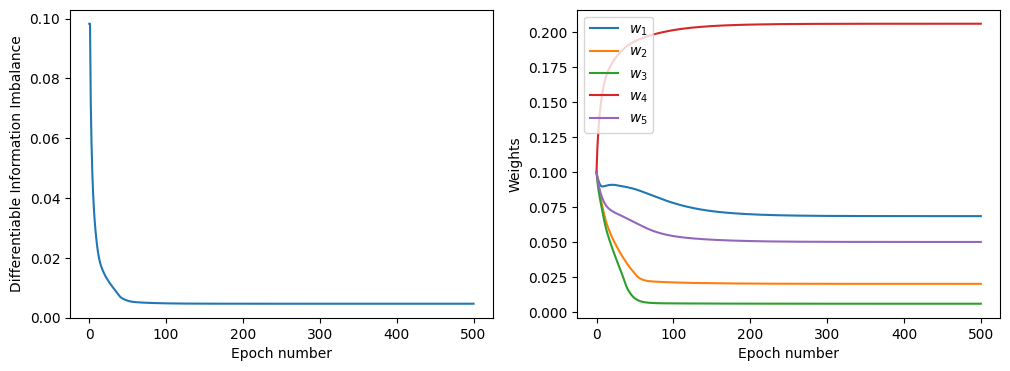

In [4]:
# plot the DII and the weights during the training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(imbs)
ax2.plot(weights[:, 0], label="$w_1$")
ax2.plot(weights[:, 1], label="$w_2$")
ax2.plot(weights[:, 2], label="$w_3$")
ax2.plot(weights[:, 3], label="$w_4$")
ax2.plot(weights[:, 4], label="$w_5$")

ax1.set(ylabel="Differentiable Information Imbalance", xlabel="Epoch number")
ax2.set(ylabel="Weights", xlabel="Epoch number")
ax2.legend()
plt.show()

The plots above show the convergence of the DII (left panel) and of the feature weights (right panel) as a function of the epoch number.

In this simple example we employed no decay schedule for the learning rate (argument 'learning_rate_decay'), although possible options are 'cos' (cosine decay) and 'exp' (learning rate is halved every 10 epochs). Although these schedules avoid "overshooting" the minimum and can improve the optimization of the DII, we suggest to always perform a first optimization in absence of any learning rate decay schedule, to verify that the number of epoches (argument 'num_epochs') is appropriate to ensure convergence.

In particularly noisy data sets, strategies to speed up and improve the DII optimization include the use of mini-batches (argument 'batches_per_epoch') coupled with more sophisticated optimizers (e.g. 'adam'), and the use of a larger neighborhood size for setting the parameter $\lambda$ adaptively (arguments 'k_init' and 'k_final').
Viable options are setting 'batches_per_epoch' such that each mini-batch contains ~100 points, and setting 'k_init' and 'k_final' such that ~5% of the points are included in each neighborhood. For example, if the original data set contains $N=500$ points, setting 'batches_per_epoch' to 5 results in mini-batches of $N'=100$ points each, and setting 'k_init' and 'k_final' to 5 allows selecting 5% of the points in each mini-batch:

In [5]:
# train the DII to recover ground-truth metric
dii = DiffImbalance(
    data_A=data_A,  # matrix of shape (N,D_A)
    data_B=data_B,  # matrix of shape (N,D_B)
    periods_A=None,
    periods_B=None,
    seed=0,
    num_epochs=500,
    batches_per_epoch=5,  # no mini-batches
    l1_strength=0.0,  # no l1 regularization
    point_adapt_lambda=True,
    k_init=5,
    k_final=5,
    params_init=None,  # automatically set to [0.1,0.1,0.1,0.1,0.1]
    optimizer_name="adam",  # possible choices: "sgd", "adam", "adamw"
    learning_rate=1e-2,
    learning_rate_decay="cos",  # possible choices: None, "cos", "exp"
    num_points_rows=None,
)
weights, imbs = dii.train()  # the outputs can also be accessed after training
# with dii.params_training and dii.imbs_training

print(f"Ground truth weights = {weights_ground_truth}\n")

# scale learnt weights in same range of ground-truth ones (same magnitude of the largest one)
print(
    f"Learnt weights: {np.abs(weights[-1]) / (np.max(np.abs(weights[-1])) / np.max(weights_ground_truth))}"
)

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Ground truth weights = [10.   3.   1.  30.   7.3]

Learnt weights: [10.04  2.86  0.57 30.    7.3 ]


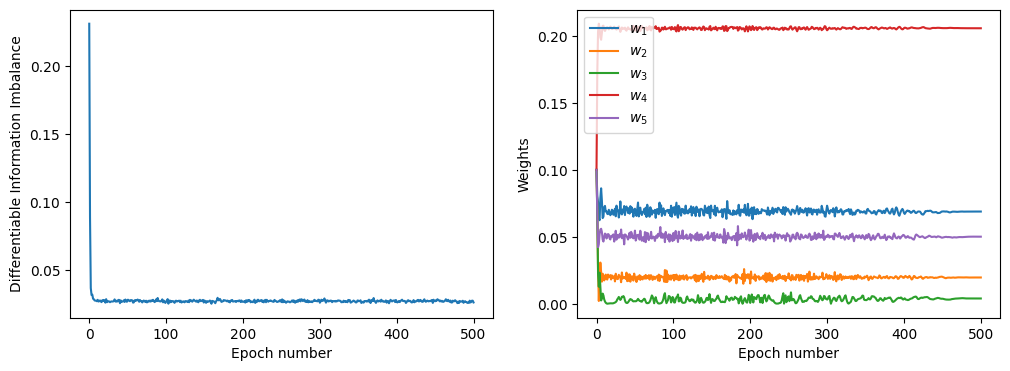

In [6]:
# plot the DII and the weights during the training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(imbs)
ax2.plot(weights[:, 0], label="$w_1$")
ax2.plot(weights[:, 1], label="$w_2$")
ax2.plot(weights[:, 2], label="$w_3$")
ax2.plot(weights[:, 3], label="$w_4$")
ax2.plot(weights[:, 4], label="$w_5$")

ax1.set(ylabel="Differentiable Information Imbalance", xlabel="Epoch number")
ax2.set(ylabel="Weights", xlabel="Epoch number")
ax2.legend()
plt.show()

In this case, the panel on the left depicts the DII computed, at each training epoch, over the last mini-batch employed in that epoch.
The DII can be computed on the full data set after convergence using the method 'return_final_dii'. For details on its arguments refer to the DADApy documentation: https://dadapy.readthedocs.io/en/latest/modules.html.

In [7]:
imb_final, _ = dii.return_final_dii(
    compute_error=False, ratio_rows_columns=None, seed=0, discard_close_ind=0
)
print(f"Optimal DII over full data set: {imb_final:2f}")  # can also be accessed
# through dii.imb_final

Optimal DII over full data set: 0.011225


## Greedy Feature Search: Forward Search Implementation

We do a similar _greedy_ search approach as done in the standard information imbalance. This is called the "forward" _greedy_ search, since we start with the least number of features (1) and then successively add features one by one to get the most optimal n-plet feature sets. 

In the following example, we want to recover the addition of features one-by-one in the same order as the weights are arranged.
Basically, the optimal n-plets for each value of n should be:
- n=1 -> [3]
- n=2 -> [0, 3]
- n=3 -> [0, 3, 4]
- n=4 -> [0, 1, 3, 4]
- n=5 -> [0, 1, 2, 3, 4]

This process is called the _greedy_ approach since we don't explore every combinatorially possible combination of features, since that would be computationally untenable for realistic datasets. Instead, we choose the `n_best` optimal features from an optimization step for a given n-plet, and add every possible feature to set and then estimate the DII. Then we choose the `n_best` optimal features (those with the least DII) from this step to proceed to the next step of the optimization. This parameter can be considered to control the degree of _greediness_ of the feature selection.

The "forward" _greedy_ search is the recommended approach to use when one is looking to select few relevant features (compared to the total possible number of features).

In [8]:
# train the DII to recover ground-truth metric
dii = DiffImbalance(
    data_A,
    data_B,
    periods_A=None,
    periods_B=None,
    seed=0,
    num_epochs=10,
    batches_per_epoch=5,
    l1_strength=0.0,
    point_adapt_lambda=True,
    k_init=5,
    k_final=5,
    lambda_factor=1e-1,
    params_init=None,
    optimizer_name="sgd",
    learning_rate=1e-1,
    learning_rate_decay="cos",
    num_points_rows=None,
)

weights, imbs = dii.train()

Training:   0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
# [[3], [0, 3], [0, 3, 4], [0, 1, 3, 4], [0, 1, 2, 3, 4]]
(
    feature_sets_fw,
    diis_fw,
    errors_fw,
    weights_fw,
) = dii.forward_greedy_feature_selection(
    n_features_max=5,
    n_best=10,
    compute_error=True,
    ratio_rows_columns=1,
    seed=0,
    discard_close_ind=0,
    num_epochs=50,
)

diis_fw_array = np.array(diis_fw)


FORWARD GREEDY SEARCH STARTS WITH ALL 5 FEATURES


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: feature set = 0, DII = 0.8999369144439697



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: feature set = 1, DII = 0.9869815111160278



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: feature set = 2, DII = 0.9980540871620178



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: feature set = 3, DII = 0.24966953694820404



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: feature set = 4, DII = 0.9708154797554016

Best single feature: 3, DII: 0.24966953694820404
Selected 5 best candidates for next iteration

Optimal weights for feature set [3]: [0.  0.  0.  0.1 0. ]



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 0, current feature set = [0, 3], DII = 0.09266918152570724



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 1, current feature set = [1, 3], DII = 0.23949241638183594



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [2, 3], DII = 0.2464694380760193



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 4, current feature set = [3, 4], DII = 0.17840220034122467



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 1, current feature set = [0, 1], DII = 0.8793095946311951



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [0, 2], DII = 0.8978637456893921



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 4, current feature set = [0, 4], DII = 0.8358938097953796



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 1, current feature set = [1, 4], DII = 0.9284020662307739



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [2, 4], DII = 0.965335488319397



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [1, 2], DII = 0.9652043581008911

Adding feature 0, best DII: 0.09266918152570724
Current best feature set: [0, 3], DII: 0.09266918152570724
Selected 10 best candidates for next iteration



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 3]: [0.04 0.   0.   0.13 0.  ]



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 1, current feature set = [0, 1, 3], DII = 0.07906471192836761



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [0, 2, 3], DII = 0.09181760251522064



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 4, current feature set = [0, 3, 4], DII = 0.025932028889656067



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 1, current feature set = [1, 3, 4], DII = 0.16652920842170715



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [2, 3, 4], DII = 0.1782713383436203



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [1, 2, 3], DII = 0.23630225658416748



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 1, current feature set = [0, 1, 4], DII = 0.8256107568740845



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [0, 2, 4], DII = 0.8346009850502014



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [0, 1, 2], DII = 0.873705267906189



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [1, 2, 4], DII = 0.9206231832504272

Adding feature 4, best DII: 0.025932028889656067
Current best feature set: [0, 3, 4], DII: 0.025932028889656067
Selected 10 best candidates for next iteration



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 3, 4]: [0.05 0.   0.   0.16 0.04]



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 1, current feature set = [0, 1, 3, 4], DII = 0.02279951237142086



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [0, 2, 3, 4], DII = 0.02593725360929966



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [0, 1, 2, 3], DII = 0.07835109531879425



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [1, 2, 3, 4], DII = 0.16602429747581482



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [0, 1, 2, 4], DII = 0.8103418350219727

Adding feature 1, best DII: 0.02279951237142086
Current best feature set: [0, 1, 3, 4], DII: 0.02279951237142086
Selected 5 best candidates for next iteration



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 1, 3, 4]: [0.06 0.02 0.   0.18 0.05]



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Forward iteration: added feature = 2, current feature set = [0, 1, 2, 3, 4], DII = 0.02285277657210827

Adding feature 2, best DII: 0.02285277657210827
Current best feature set: [0, 1, 2, 3, 4], DII: 0.02285277657210827
Selected 1 best candidates for next iteration



Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 1, 2, 3, 4]: [0.07 0.02 0.   0.21 0.05]



In [10]:
print("Forward DIIs:", diis_fw)
print("Forward Errors:", errors_fw)
print("Forward Weights:", weights_fw)

print("\nOriginal weights:", weights_ground_truth)
print(
    f"\nLearnt weights for the full feature space: {np.abs(weights_fw[-1]) / (np.max(np.abs(weights_fw[-1])) / np.max(weights_ground_truth))}"
)
print(
    f"\nAll weights along the feature selection:\n {np.abs(weights_fw) / (np.max(np.abs(weights_fw)) / np.max(weights_ground_truth))}"
)

Forward DIIs: [0.24966954, 0.09266918, 0.025932029, 0.022799512, 0.022852777]
Forward Errors: [Array(0.01, dtype=float32), 0.0050238348, 0.00054343726, 0.00034482678, 0.0003450679]
Forward Weights: [array([0. , 0. , 0. , 0.1, 0. ]), Array([0.04, 0.  , 0.  , 0.13, 0.  ], dtype=float32), Array([0.05, 0.  , 0.  , 0.16, 0.04], dtype=float32), Array([0.06, 0.02, 0.  , 0.18, 0.05], dtype=float32), Array([0.07, 0.02, 0.  , 0.21, 0.05], dtype=float32)]

Original weights: [10.   3.   1.  30.   7.3]

Learnt weights for the full feature space: [10.16  2.78  0.59 30.    7.39]

All weights along the feature selection:
 [[ 0.    0.    0.   14.6   0.  ]
 [ 6.27  0.    0.   19.68  0.  ]
 [ 7.88  0.    0.   23.32  5.82]
 [ 9.09  2.48  0.   26.84  6.63]
 [10.16  2.78  0.59 30.    7.39]]


## Greedy Feature Search: Backward Search Implementation

Here we implement the "backward" _greedy_ search approach, similar to that done in the cython version of the differentiable information imbalance.
Opposite in philosophy to the "forward" _greedy_ search, we start with all the features and then successively remove features one by one to get the most optimal n-plet feature sets. 

In the following example, we want to recover the removal of features one-by-one in the same order as the weights are arranged.
Basically, the optimal n-plets for each value of n should be:
- n=5 -> [0, 1, 2, 3, 4]
- n=4 -> [0, 1, 3, 4]
- n=3 -> [0, 3, 4]
- n=2 -> [0, 3]
- n=1 -> [3]

Similar to the "forward" _greedy_ search implementation, we choose the `n_best` optimal features from an optimization step for a given n-plet, and remove every possible feature from this set and then estimate the DII. Then we choose the `n_best` optimal features (those with the least DII) from this step to proceed to the next step of the optimization. This parameter can be considered to control the degree of _greediness_ of the feature selection.

The "backward" _greedy_ search is the recommended approach to use when one is looking to select a significant number of relevant features (compared to the total possible number of features), or a case where one just wants to eliminate a few uninformative features.

In [11]:
# train the DII to recover ground-truth metric
dii = DiffImbalance(
    data_A,
    data_B,
    periods_A=None,
    periods_B=None,
    seed=0,
    num_epochs=10,
    batches_per_epoch=5,
    l1_strength=0.0,
    point_adapt_lambda=True,
    k_init=5,
    k_final=5,
    lambda_factor=1e-1,
    params_init=None,
    optimizer_name="sgd",
    learning_rate=1e-1,
    learning_rate_decay="cos",
    num_points_rows=None,
)

weights, imbs = dii.train()

Training:   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
# [[0, 1, 2, 3, 4], [0, 1, 3, 4], [0, 3, 4], [0, 3], [3]]
(
    feature_sets_bw,
    diis_bw,
    errors_bw,
    weights_bw,
) = dii.backward_greedy_feature_selection(
    n_features_min=1,
    n_best=10,
    compute_error=True,
    ratio_rows_columns=1,
    seed=0,
    discard_close_ind=0,
    num_epochs=50,
)

diis_bw_array = np.array(diis_bw)


BACKWARD GREEDY SEARCH STARTS WITH ALL 5 FEATURES
Initial DII with all features: 0.022772416472434998

Optimal weights for initial feature set [0, 1, 2, 3, 4]: [0.07 0.02 0.   0.21 0.05]

Backward iteration with 5 features


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 0, current feature set = [1, 2, 3, 4], DII = 0.16650478541851044



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 1, current feature set = [0, 2, 3, 4], DII = 0.02593725360929966



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 2, current feature set = [0, 1, 3, 4], DII = 0.022799985483288765



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [0, 1, 2, 4], DII = 0.8162417411804199



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 4, current feature set = [0, 1, 2, 3], DII = 0.07873981446027756

Removing feature 2, best DII: 0.022799985483288765


Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 1, 3, 4]: [0.06 0.02 0.   0.18 0.05]

Current best feature set: [0, 1, 3, 4], DII: 0.022799985483288765
Selected 5 best candidates for next iteration

Backward iteration with 4 features


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 0, current feature set = [1, 3, 4], DII = 0.16643910109996796



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 1, current feature set = [0, 3, 4], DII = 0.02594284899532795



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [0, 1, 4], DII = 0.8212908506393433



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 4, current feature set = [0, 1, 3], DII = 0.0785510316491127



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 0, current feature set = [2, 3, 4], DII = 0.1782713383436203



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [0, 2, 4], DII = 0.8310080766677856



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 4, current feature set = [0, 2, 3], DII = 0.09189017117023468



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 0, current feature set = [1, 2, 3], DII = 0.23976528644561768



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [0, 1, 2], DII = 0.873705267906189



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [1, 2, 4], DII = 0.9206231832504272

Removing feature 1, best DII: 0.02594284899532795


Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 3, 4]: [0.05 0.   0.   0.16 0.04]

Current best feature set: [0, 3, 4], DII: 0.02594284899532795
Selected 10 best candidates for next iteration

Backward iteration with 3 features


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 0, current feature set = [3, 4], DII = 0.1784670203924179



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [0, 4], DII = 0.8345729112625122



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 4, current feature set = [0, 3], DII = 0.09218078851699829



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 0, current feature set = [1, 3], DII = 0.2390100210905075



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [0, 1], DII = 0.8793095946311951



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 0, current feature set = [2, 3], DII = 0.24899360537528992



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [0, 2], DII = 0.8961151838302612



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [1, 4], DII = 0.9284020662307739



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [2, 4], DII = 0.965335488319397



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [1, 2], DII = 0.9652043581008911

Removing feature 4, best DII: 0.09218078851699829


Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [0, 3]: [0.04 0.   0.   0.13 0.  ]

Current best feature set: [0, 3], DII: 0.09218078851699829
Selected 10 best candidates for next iteration

Backward iteration with 2 features


Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 0, current feature set = [3], DII = 0.24966953694820404



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [0], DII = 0.8999369144439697



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [4], DII = 0.9708154797554016



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [1], DII = 0.9869815111160278



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Backward iteration: removed feature = 3, current feature set = [2], DII = 0.9980540871620178

Removing feature 0, best DII: 0.24966953694820404


Training:   0%|          | 0/50 [00:00<?, ?it/s]


Optimal weights for feature set [3]: [0.  0.  0.  0.1 0. ]

Current best feature set: [3], DII: 0.24966953694820404
Selected 5 best candidates for next iteration



In [13]:
print("Backward DIIs:", diis_bw)
print("Backward Errors:", errors_bw)
print("Backward Weights:", weights_bw)

print("\nOriginal weights:", weights_ground_truth)
print(
    f"\nLearnt weights for the full feature space: {np.abs(weights_bw[0]) / (np.max(np.abs(weights_bw[0])) / np.max(weights_ground_truth))}"
)
print(
    f"\nAll weights along the feature selection:\n {np.abs(weights_bw) / (np.max(np.abs(weights_bw)) / np.max(weights_ground_truth))}"
)

Backward DIIs: [Array(0.02, dtype=float32), 0.022799985, 0.025942849, 0.09218079, 0.24966954]
Backward Errors: [Array(0., dtype=float32), 0.00034475446, 0.0005474836, 0.004991478, 0.0075137406]
Backward Weights: [Array([0.07, 0.02, 0.  , 0.21, 0.05], dtype=float32), Array([0.06, 0.02, 0.  , 0.18, 0.05], dtype=float32), Array([0.05, 0.  , 0.  , 0.16, 0.04], dtype=float32), Array([0.04, 0.  , 0.  , 0.13, 0.  ], dtype=float32), Array([0. , 0. , 0. , 0.1, 0. ], dtype=float32)]

Original weights: [10.   3.   1.  30.   7.3]

Learnt weights for the full feature space: [10.05  2.96  0.2  30.    7.32]

All weights along the feature selection:
 [[10.05  2.96  0.2  30.    7.32]
 [ 9.08  2.48  0.   26.8   6.62]
 [ 7.87  0.    0.   23.29  5.81]
 [ 6.26  0.    0.   19.65  0.  ]
 [ 0.    0.    0.   14.58  0.  ]]
